In [9]:
from repath.experiments.tissuedet import *

set_seed(global_seed)
detection_level = 5
final_level = 7
morphology_transform1 = MaxPoolTransform(level_in=detection_level, level_out=final_level)
morphology_transform2 = SizedClosingTransform(level_in=final_level)
morphology_transform3 = FillHolesTransform(level_in=final_level)
morphology_transforms = [morphology_transform1, morphology_transform2, morphology_transform3]
tissue_detector_test = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)
calc_tissue_conf_mat(tissue_detector_test, "greyscale_maxpool", final_level, experiment_root)
get_output_images(tissue_detector_test, "greyscale_maxpool", final_level, experiment_root)
write_contours_to_file(tissue_detector_test, "greyscale_maxpool", final_level, experiment_root, level_out=0)

indexing IC-CX-00001-01.isyntax
indexing IC-CX-00002-01.isyntax
indexing IC-CX-00004-01.isyntax
indexing IC-CX-00005-01.isyntax
indexing IC-CX-00006-02.isyntax
indexing IC-CX-00008-01.isyntax
indexing IC-CX-00010-01.isyntax
indexing IC-CX-00014-01.isyntax
indexing IC-CX-00020-01.isyntax
indexing IC-EN-02079-01.isyntax
indexing IC-EN-02081-01.isyntax
indexing IC-EN-02084-01.isyntax
indexing IC-EN-02086-01.isyntax
indexing IC-EN-02089-01.isyntax
indexing IC-EN-02092-01.isyntax
indexing IC-EN-02095-01.isyntax
indexing IC-CX-00001-01.isyntax


IndexError: boolean index did not match indexed array along dimension 0; dimension is 428 but corresponding boolean dimension is 107

In [ ]:
# path = project_root() / 'experiments' / 'tissue' / 'greyscale' / 'outline_output_images' / 'IC-CX-00001-01.jpg'
path = project_root() / 'experiments' / 'tissue' / 'greyscale_fill_holes' / 'greyscale_fill_holes_confidence_matrix.png'

from PIL import Image
Image.open(path)

In [22]:
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SimpleClosingTransform, NullTransform, SizedClosingTransform, FillHolesTransform

level_in=7

morph_transform1 = SizedClosingTransform(level_in=level_in)
morph_transform2 = FillHolesTransform(level_in=level_in)
morph_transforms = [morph_transform1, morph_transform2]

from repath.preprocess.tissue_detection import MedianBlur, GaussianBlur

pre_transform1 = MedianBlur(filter_size=2)
pre_transform2 = GaussianBlur(sigma=2)
pre_transforms = [pre_transform1, pre_transform2]

tissue_detector_test = TissueDetectorGreyScale(grey_level=0.85, morph_transform=morph_transforms)

In [12]:
from repath.experiments.tissuedet import *
from repath.utils.export import convert_mask_to_json
from repath.preprocess.tissue_detection.tissue_metrics import get_slide_output_masks, create_colour_output, create_overlay_output
from repath.utils.geometry import Size

level_in = 5
datset = tissue.tissue()
for idx, path in enumerate(datset.paths.slide[7:8]):
    print(path)
    annot_path = datset.paths.annotation.iloc[idx]
    test_path = project_root() / datset.root / path
    truth_path = project_root() / datset.root / annot_path
    with datset.slide_cls(test_path) as slide:
        thumb = slide.get_thumbnail(level_in)
        tissue_mask_detected = tissue_detector(thumb)
        if level_in >= len(slide.dimensions):
            request_level = len(slide.dimensions) - 1
            lev_diff = level_in - request_level
            max_level_dim = slide.dimensions[-1]
            requested_level_size = Size(max_level_dim.width // 2 ** lev_diff, max_level_dim.height // 2 ** lev_diff)
            labels_shape = requested_level_size.as_shape()
        else:
            labels_shape = slide.dimensions[level_in].as_shape()
        tissue_annotations = datset.load_annotations(truth_path)
        scale_factor = 2 ** level_in
        tissue_mask_annotated = tissue_annotations.render(labels_shape, scale_factor)
        tn_arr, fp_arr, fn_arr, tp_arr = get_slide_output_masks(tissue_mask_annotated, tissue_mask_detected)
        colour_thumb = create_colour_output(tn_arr, fp_arr, fn_arr, tp_arr)
        #outline_thumb = create_overlay_output(thumb, tissue_mask_detected)

images/IC-CX-00014-01.isyntax


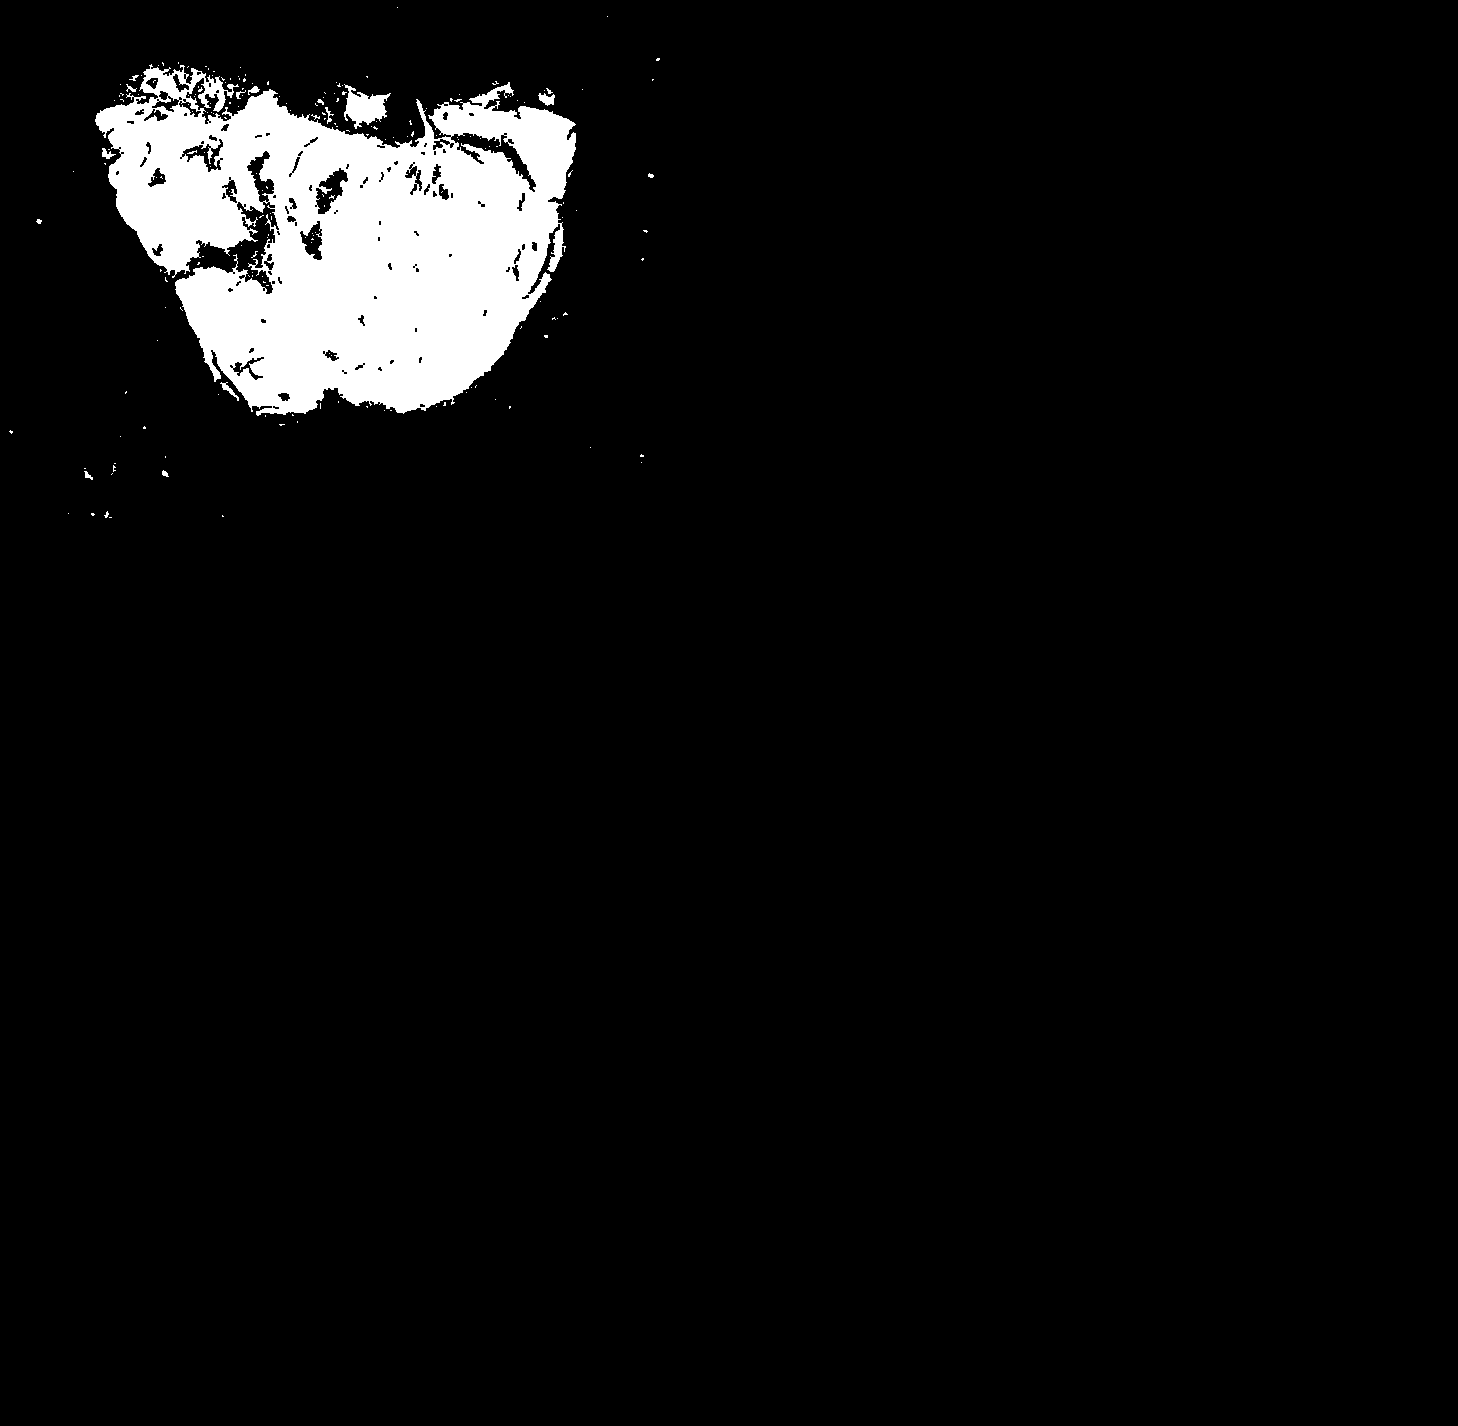

In [13]:
Image.fromarray(np.array(tissue_mask_detected*255, dtype=np.uint8))

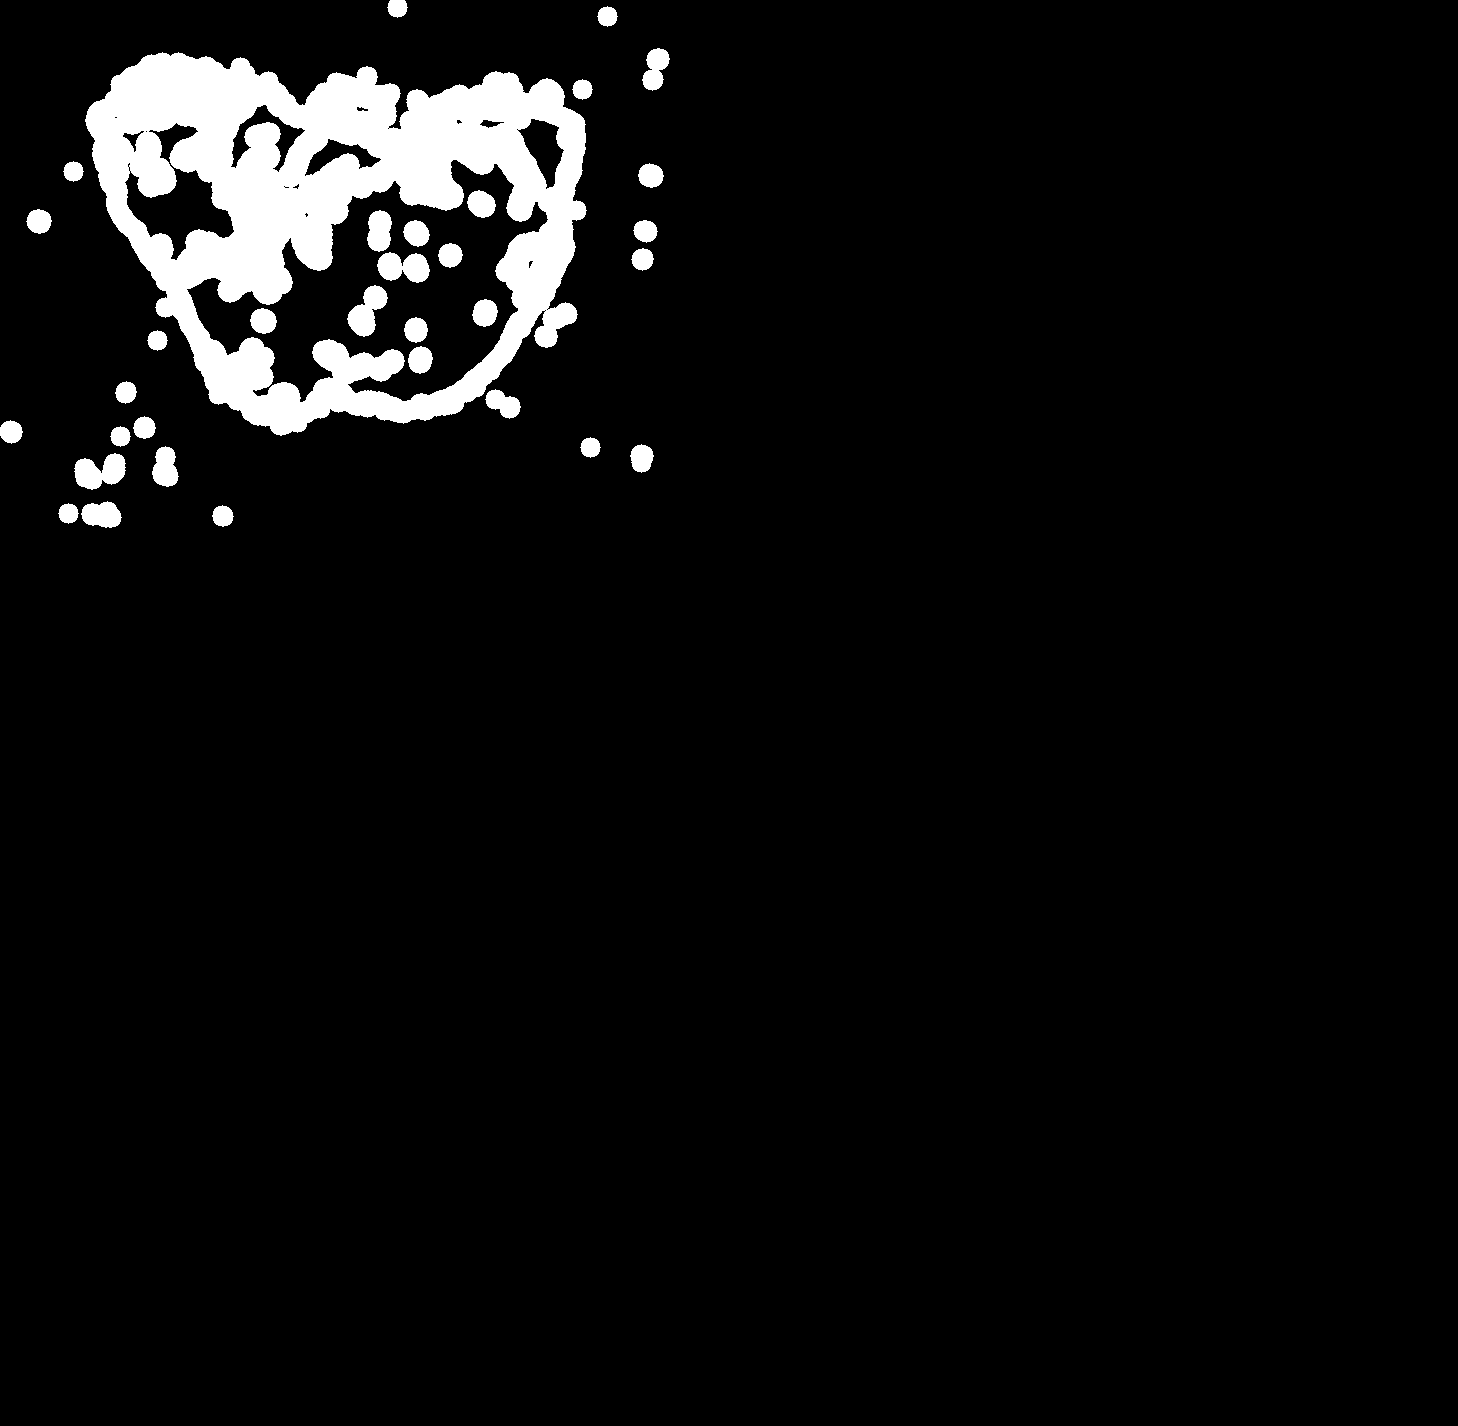

In [16]:
import cv2

blank_im = np.zeros(tissue_mask_detected.shape, dtype=np.uint8)
contours, hierarchy = cv2.findContours(np.array(tissue_mask_detected, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_im = cv2.drawContours(blank_im, contours, -1, [255,255,255], 20)
Image.fromarray(np.array(contour_im, dtype=np.uint8))

In [18]:
np.sum(contour_im > 0)

107610

In [ ]:
import cv2

level_in=7
level_out=7

# convert to PIL image
im_out = Image.fromarray(np.array(tissue_mask_detected*255, dtype=np.uint8))

# calculate new image size
level_diff = level_in - level_out
size_diff = 2 ** level_diff
new_size = (im_out.size[0] * size_diff, im_out.size[1] * size_diff)

# resize image
im_resize = im_out.resize(new_size, Image.BOX)

contours, hierarchy = cv2.findContours(np.array(tissue_mask_detected, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
has_parent = [ct > -1 for ct in hierarchy[0, :, 3]]
hierarchy[0, has_parent, :]

In [ ]:
has_child = [ct > -1 for ct in hierarchy[0, :, 2]]
hierarchy[0, has_child, :]

In [ ]:
no_parent_no_child = np.logical_and(np.logical_not(has_parent), np.logical_not(has_child))
np.sum(no_parent_no_child)

In [ ]:
parent_no_child = np.logical_and(has_parent, np.logical_not(has_child))
np.sum(parent_no_child)

In [ ]:
child_no_parent = np.logical_and(np.logical_not(has_parent), has_child)
np.sum(child_no_parent)

In [ ]:
parent_and_child = np.logical_and(has_parent, has_child)
np.sum(parent_and_child)

In [ ]:
hierarchy[0, parent_and_child, :]

In [ ]:
parent_and_child_list = np.arange(len(contours))[parent_and_child]
grandkids_mask = np.isin(hierarchy[0, :, 3], parent_and_child_list)


In [ ]:
np.sum(np.logical_and(grandkids_mask, parent_no_child))

In [ ]:
no_parent_no_child_list = np.arange(len(contours))[no_parent_no_child]
grandkids_list = np.arange(len(contours))[grandkids_mask]
parents_list = np.arange(len(contours))[child_no_parent]
top_level_list = np.hstack((no_parent_no_child_list, grandkids_list, parents_list))


In [ ]:
json_points = []

for ct in top_level_list:
    child_mask = hierarchy[0, :, 3] == ct
    got_kids = np.sum(child_mask) > 0
    if got_kids:
        polygon1 = contours[ct]
        pts = []
        for pt in range(polygon1.shape[0]):
            pnt = polygon1[pt][0].tolist()
            pts.append(pnt)
        json_polygon = [pts]
        kids = np.array(contours, dtype=object)[np.arange(len(contours))[child_mask]]
        for kid in kids:
            pts = []
            for pt in range(kid.shape[0]):
                pnt = kid[pt][0].tolist()
                pts.append(pnt)
            json_polygon.append(pts)
        json_points.append(json_polygon)
    else:
        pts = []
        for pt in range(contours[ct].shape[0]):
            pnt = contours[ct][pt][0].tolist()
            pts.append(pnt)
        json_points.append([pts])

In [ ]:
npolys = [len(jp) for jp in json_points]
np.array(npolys)[np.array(npolys) > 1]

In [ ]:
len(npolys)

In [ ]:
cnt

# Get tissue not tissue patches for game

In [29]:
import cv2

def patches_for_game(tissue_detector_test: TissueDetector, label: str, level_in: int, base_dir: Path) -> None:
    """
    For a tissue detector this gets tissue no tissue patches for gamification app
    
    Args:
            tissue_detector_test (TissueDetector): A class of tissue detector to test
            label (str): A label to add to filenames for naming output of this experiment
            level_in (int): The level at which to carry out the tissue detection
            best_dir (path): directory to write out data

    """
    tissue_dataset = tissue.tissue()
    psize = 2 ** level_in
    patch_finder = GridPatchFinder(labels_level=level_in, patch_level=0, patch_size=psize, stride=psize, remove_background=False)

    # create blank slides with just tissue detector labels
    tissue_patchsets_detected = SlidesIndex.index_dataset(tissue_dataset, tissue_detector_test, patch_finder, notblank=False)

    # find patches close to edges
    tissue_patchsets_edges = find_patches_close_to_edge(tissue_dataset, tissue_patchsets_detected, tissue_detector_test)

    # combine into one
    tissue_patches_edges = CombinedIndex.for_slide_indexes([tissue_patchsets_edges])

    # filter to get only edge patches
    tissue_patches_edges.patches_df = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.edge_patch == True]

    # get sample of tissue_patches
    tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 1]
    tissue_patches_sample = tissue_patches_sample.sample(n=1000, axis=0)

    # get sample of non tissue_patches
    non_tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 0]
    non_tissue_patches_sample = non_tissue_patches_sample.sample(n=1000, axis=0)

    # combine into one set
    combined_sample = pd.concat((tissue_patches_sample, non_tissue_patches_sample), axis=0)
    tissue_patches_edges.patches_df = combined_sample

    # save patches
    tissue_patches_edges.save_patches(output_dir=Path(project_root(),"experiments","tissue","patches_for_game"))



NameError: name 'TissueDetector' is not defined

In [47]:
def find_patches_close_to_edge(datset, slides_index, tissue_detector):

    for sps in slides_index:
        path = datset.paths.slide[sps.slide_idx]
        test_path = test_path = project_root() / datset.root / path
        with datset.slide_cls(test_path) as slide:
            thumb = slide.get_thumbnail(level_in)
        tissue_mask_detected = tissue_detector(thumb)
        # find patches close to the contours of the image
        blank_im = np.zeros(tissue_mask_detected.shape, dtype=np.uint8)
        contours, hierarchy = cv2.findContours(np.array(tissue_mask_detected, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_im = cv2.drawContours(blank_im, contours, -1, [255,255,255], 20)
        contour_im = contour_im > 0
        df = to_frame_with_locations(contour_im, "edge_patch")
        col_nams = sps.patches_df.columns.tolist()
        col_nams.append("edge_patch")
        patches_df = pd.concat((sps.patches_df, df.iloc[:, 2:3]), axis=1, ignore_index=True)
        patches_df.columns = col_nams
        sps.patches_df = patches_df
        
    return slides_index

In [55]:
tissue_dataset = tissue.tissue()
psize = 2 ** level_in
patch_finder = GridPatchFinder(labels_level=level_in, patch_level=0, patch_size=psize, stride=psize, remove_background=False)

# create blank slides with just tissue detector labels
tissue_patchsets_detected = SlidesIndex.index_dataset(tissue_dataset, tissue_detector_test, patch_finder, notblank=False)

# find patches close to edges
tissue_patchsets_edges = find_patches_close_to_edge(tissue_dataset, tissue_patchsets_detected, tissue_detector_test)

# combine into one
tissue_patches_edges = CombinedIndex.for_slide_indexes([tissue_patchsets_edges])

# filter to get only edge patches
tissue_patches_edges.patches_df = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.edge_patch == True]

# get sample of tissue_patches
tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 1]
tissue_patches_sample = tissue_patches_sample.sample(n=1000, axis=0)

# get sample of non tissue_patches
non_tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 0]
non_tissue_patches_sample = non_tissue_patches_sample.sample(n=1000, axis=0)

# combine into one set
combined_sample = pd.concat((tissue_patches_sample, non_tissue_patches_sample), axis=0)
tissue_patches_edges.patches_df = combined_sample

# save patches
tissue_patches_edges.save_patches(output_dir=Path(project_root(),"experiments","tissue","patches_for_game"))

indexing IC-CX-00001-01.isyntax
indexing IC-CX-00002-01.isyntax
indexing IC-CX-00004-01.isyntax
indexing IC-CX-00005-01.isyntax
indexing IC-CX-00006-02.isyntax
indexing IC-CX-00008-01.isyntax
indexing IC-CX-00010-01.isyntax
indexing IC-CX-00014-01.isyntax
indexing IC-CX-00020-01.isyntax
indexing IC-EN-02079-01.isyntax
indexing IC-EN-02081-01.isyntax
indexing IC-EN-02084-01.isyntax
indexing IC-EN-02086-01.isyntax
indexing IC-EN-02089-01.isyntax
indexing IC-EN-02092-01.isyntax
indexing IC-EN-02095-01.isyntax


Writing patches for images/IC-CX-00001-01.isyntax
Writing patches for images/IC-CX-00002-01.isyntax
Writing patches for images/IC-CX-00004-01.isyntax
Writing patches for images/IC-CX-00005-01.isyntax
Writing patches for images/IC-CX-00006-02.isyntax
Writing patches for images/IC-CX-00008-01.isyntax
Writing patches for images/IC-CX-00010-01.isyntax
Writing patches for images/IC-CX-00014-01.isyntax
Writing patches for images/IC-CX-00020-01.isyntax
Writing patches for images/IC-EN-02079-01.isyntax
Writing patches for images/IC-EN-02081-01.isyntax
Writing patches for images/IC-EN-02084-01.isyntax
Writing patches for images/IC-EN-02086-01.isyntax
Writing patches for images/IC-EN-02089-01.isyntax
Writing patches for images/IC-EN-02092-01.isyntax
Writing patches for images/IC-EN-02095-01.isyntax


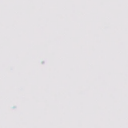

In [71]:
path = project_root() / 'experiments' / 'tissue' / 'patches_for_game' / 'background' / 'images-IC-EN-02079-01.isy-40064-18048.png'

from PIL import Image
Image.open(path)

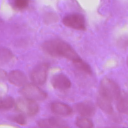

In [72]:
path = project_root() / 'experiments' / 'tissue' / 'patches_for_game' / 'tissue' / 'images-IC-EN-02092-01.isy-58880-19712.png'

from PIL import Image
Image.open(path)

           x      y  label  transform  edge_patch
0          0      0    0.0          1       False
1        128      0    0.0          1       False
2        256      0    0.0          1       False
3        384      0    0.0          1       False
4        512      0    0.0          1       False
...      ...    ...    ...        ...         ...
72327  20992  54656    0.0          1       False
72328  21120  54656    0.0          1       False
72329  21248  54656    0.0          1       False
72330  21376  54656    0.0          1       False
72331  21504  54656    0.0          1       False

[72332 rows x 5 columns]
